In [1]:
!git clone https://github.com/ahmed-h-elsheikh/polychaos-learn

fatal: destination path 'polychaos-learn' already exists and is not an empty directory.


In [2]:
# polychaos: deg -->, until mem brake
# 5, 10k - same
# hermite phys, prob (x, t - legendre)

In [3]:
# generate normal (uniform[-1, 1])features --> input model --> polycahos input = (x, t)
# normal (hermite prob) perm 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import random
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.preprocessing import StandardScaler

from pclearn import OrthogonalPolynomialsFeatures
from diffusion_equation import compute_solution
import torch
import pandas as pd

# Read from file

In [2]:
# sim_data: pres, swat, soil
sim_data = np.load("data-100-new-two-sigma/sim_100.npy").astype(np.float32)#[sim_nidexes]

pwat_list = np.load("data-100-new-two-sigma/pwat_100.npy").astype(np.float32)
poil_list = np.load("data-100-new-two-sigma/poil_100.npy").astype(np.float32)
kwat_list = np.load("data-100-new-two-sigma/kwat_100.npy").astype(np.float32)
koil_list = np.load("data-100-new-two-sigma/koil_100.npy").astype(np.float32)

In [3]:
niter = 100
nx, ny = 64, 64
t_final = 3.0
dt = t_final / niter
dx, dy = 1 / nx, 1 / ny

indexes_high = np.argwhere(sim_data[:, :, :, :, :, 1] > 0.1)
indexes_low = np.argwhere(sim_data[:, :, :, :, :, 1] > 0)

indexes_low = indexes_low[np.random.randint(0, len(indexes_low),len(indexes_high) // 2)]
indexes = np.vstack([indexes_low, indexes_high])

simulation_data = np.zeros((indexes.shape[0], 3))
for i, row in enumerate(indexes):
    simulation_data[i] = sim_data[row[0], row[1], row[2], row[3], row[4], :3]

x_list = indexes[:, 0] * dx
y_list = indexes[:, 1] * dy
t_list = indexes[:, 3] * dt

pwat_rand = pwat_list[indexes[:, -1]]
poil_rand = poil_list[indexes[:, -1]]
kwat_rand = kwat_list[indexes[:, -1]]
koil_rand = koil_list[indexes[:, -1]]

In [4]:
rand_indexes_2000 = np.load('train-indexes-2sigma-2000.npy')
rand_indexes_1000 = np.load('train-indexes-2sigma-1000.npy')
rand_indexes_500 = np.load('train-indexes-2sigma-500.npy')
rand_indexes_250 = np.load('train-indexes-2sigma-250.npy')

In [5]:
rand_indexes = rand_indexes_250

simulation_data_train = simulation_data.astype(np.float32)[rand_indexes]

x = x_list.astype(np.float32)[rand_indexes]
y = y_list.astype(np.float32)[rand_indexes]
t = t_list.astype(np.float32)[rand_indexes]


pwat = pwat_rand.astype(np.float32)[rand_indexes]
poil = poil_rand.astype(np.float32)[rand_indexes]
kwat = kwat_rand.astype(np.float32)[rand_indexes]
koil = koil_rand.astype(np.float32)[rand_indexes]

points = np.stack((t, x, y, pwat, poil, kwat, koil), -1)

In [6]:
pd.DataFrame(data=simulation_data_train, columns=['pres', 'swat', 'soil']).describe()

,pres,swat,soil
count,250.000000,2.500000e+02,250.000000
mean,0.864399,2.081448e-01,0.791855
std,0.259923,1.476092e-01,0.147609
min,0.009987,2.324586e-40,0.409828
25%,0.922301,1.129203e-01,0.676909
50%,0.975330,2.038352e-01,0.796165
75%,0.987053,3.230906e-01,0.887080
max,0.998812,5.901717e-01,1.000000


In [13]:
points_train, sim_points_train = points, simulation_data_train

In [14]:
# # configuration of simulator
# # and parametrs of reservouir
# perm = np.load('/Users/kirill/edu/3course/PINN_project/TwoPhase2/perm.npy')
# nx0, nx1 = perm.shape
# nx2 = 1
# perm = np.reshape(perm, (nx0, nx1, nx2))
# poro = 0.1 + np.zeros((nx0, nx1, nx2))

# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2

# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3

# pmin = 0.0
# pmax = 1.0

# niter = 5000
# t_final = 3.0
# dt = t_final / niter

In [15]:
# 2000
# sim_data = np.loadtxt("2000_data/sim_2k.txt", dtype=np.float32)
# x_list = np.loadtxt("2000_data/x_2k.txt", dtype=np.float32)
# y_list = np.loadtxt("2000_data/y_2k.txt", dtype=np.float32)
# t_list = np.loadtxt("2000_data/t_2k.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list

In [16]:
# # 5000 3sigma
# sim_data = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/sim_5000.txt", dtype=np.float32)
# x_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/x_5000.txt", dtype=np.float32)
# y_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/y_5000.txt", dtype=np.float32)
# t_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/t_5000.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list

In [17]:
def fix_random_seed(seed_):
    random.seed(seed_)
    np.random.seed(seed_)

In [18]:
# t, x, y, pwat, poil, kwat, koil

In [51]:
norm = StandardScaler()
norm.fit_transform(points_train)

array([[ 0.2532977 , -0.8059479 , -0.6106891 , ...,  0.6024785 ,
        -1.3535324 ,  0.6725458 ],
       [ 0.09071893, -0.8059479 , -0.556396  , ..., -0.9575239 ,
         1.3073846 , -0.5499176 ],
       [ 0.65974456, -0.8059479 ,  0.09512156, ..., -0.07886591,
         1.1235834 ,  0.80485374],
       ...,
       [ 0.9036128 , -0.17804527, -1.0993272 , ...,  1.5310026 ,
        -1.433192  ,  0.11839479],
       [-0.72217494, -0.8059479 , -1.0450342 , ..., -0.761853  ,
         0.07704914,  1.1907202 ],
       [ 0.7003892 ,  3.031235  , -0.23063722, ..., -0.37574598,
         1.3170573 ,  0.20793577]], shape=(250, 7), dtype=float32)

In [20]:
rand_seed_ = random.randint(1, 10000)  # random.randint(1, 10000)  # fix seed randomly
fix_random_seed(rand_seed_)


# load data set
# X_train, X_test, y_train, y_test = train_test_split(points, sim_data, test_size=0.3, random_state=rand_seed_)
# # X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(points_old, sim_data_old, 
# #                                                                     test_size=0.3, random_state=rand_seed_)

n_samples_train, n_features = points_train.shape

print('Working on training data of size {}'.format(points_train.shape[0]))
print('Number of features {}'.format(points_train.shape[1]))

Working on training data of size 250
Number of features 7


In [76]:
# define solver parameters
tol_eps = 1.0e-3  # tolerance
n_cv_folds = 3
alphas = np.logspace(-5, 1, 5)
l1_ratio = np.linspace(0.05, 0.95, 15)
n_max_iter = 200  # number of iteratons

fitting_method = MultiTaskElasticNetCV(l1_ratio=l1_ratio, alphas=alphas,
                              max_iter=n_max_iter, tol=tol_eps, cv=n_cv_folds,
                              fit_intercept=False, selection='random')

# define interpolation parameters
poly_degree = 8  # degree of polynomial

# hermite
# input normal ---> std scale
# u[-1, 1] legendre, expon laguerre

poly_type = ['laguerre'] * n_features  # could be different e.g. ['legendre', 'hermite']

reduction = False # ok
dlist = []
truncated_dim = 20
single_iter_dim = 15
niter = 500
nrand = 50

t_start = time.time()
orthopoly = OrthogonalPolynomialsFeatures(
    degree=poly_degree, dlist=dlist, poly_type=poly_type,
    reduction=reduction, basis_dim=truncated_dim,
    single_iter_dim=single_iter_dim, niter=niter, nrand=nrand,
    clf=fitting_method)
print('Calling OrthogonalPolynomialsFeatures in {:6f} seconds'.format(time.time() - t_start))

regression_pipeline = Pipeline(steps=[
    ('orthopoly', orthopoly),
    ('fitting_method', fitting_method)])

t_start = time.time()
regression_pipeline.fit(norm.transform(points_train), sim_points_train)
print('Linear problem (with PCE basis) has been solved in {:6f} seconds'.format(time.time() - t_start))

t_start = time.time()
y_train_pred = regression_pipeline.predict(norm.transform(points_train))
print('Prediction over the training data in {:6f} seconds'.format(time.time() - t_start))

# t_start = time.time()
# y_test_pred = regression_pipeline.predict(X_test)
# print('Prediction over the test data in {:6f} seconds'.format(time.time() - t_start))

mse_train = mean_squared_error(sim_points_train, y_train_pred)
# mse_test = mean_squared_error(y_test, y_test_pred)

print('MSE train: {}'.format(mse_train))

Calling OrthogonalPolynomialsFeatures in 0.000153 seconds
n_output_features: 6435


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0855495929718018, tolerance: 0.2563784122467041
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34297364950180054, tolerance: 0.2563784122467041
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5104052424430847, tolerance: 0.2530977129936218
  model = cd

Linear problem (with PCE basis) has been solved in 34.474351 seconds
Prediction over the training data in 0.503930 seconds
MSE train: 0.0017562188440933824


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

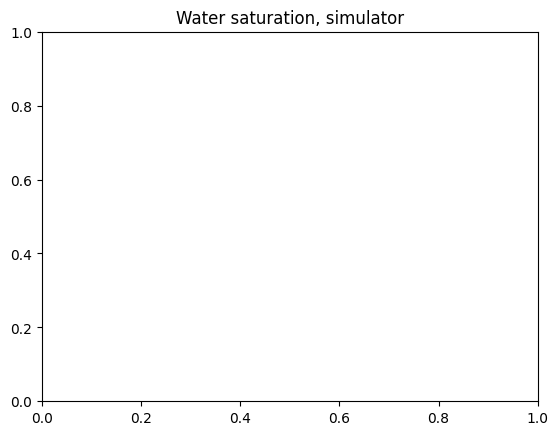

In [77]:
# def main_new(regression_pipeline, pwat=1.5, poil=2.0, kwat=1.5, koil = 0.3):
pwat=1.5
poil=2.0
kwat=1.5
koil = 0.3

perm = np.load('/Users/kirill/Desktop/perm_2.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2
vr = 0.3

if isinstance(pwat, float):
    pwat_list = pwat * torch.ones(64 * 64)
    poil_list = poil * torch.ones(64 * 64)
    kwat_list = kwat * torch.ones(64 * 64)
    koil_list = koil * torch.ones(64 * 64)

pmin = 0.0
pmax = 1.0

dt = 0.15e-1
niter = 100


swat = np.zeros((nx0, nx1, nx2))
soil = np.ones((nx0, nx1, nx2))


# pres, swat, soil = compute_solution(perm, poro,
#                                     dx0, dx1, dx2, dt * niter, niter,
#                                     pwat, kwat, poil, koil, vr,
#                                     pmin=0.0, pmax=1.0)
    
time_for_model = (niter * dt) * torch.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
points_scaled = norm.transform(
    np.stack((
        time_for_model, 
        cartesian_points[:, 0], 
        cartesian_points[:, 1],
        pwat * np.ones(64 * 64),
        poil * np.ones(64 * 64),
        kwat * np.ones(64 * 64),
        koil * np.ones(64 * 64)), -1)        
)
model_prediction = regression_pipeline.predict(points_scaled)
plt.figure()
plt.title('Water saturation, simulator')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('test_num_4/color_swat_sim_pce.png')
plt.show()

plt.figure()
plt.title('Water saturation, PCE')
plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('test_num_4/color_swat_pce.png')
plt.show()

plt.figure()
plt.title('Pressure, simulator')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('test_num_4/color_pressure_sim_pce.png')
plt.show()


plt.figure()
plt.title('Pressure, PCE')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('test_num_4/color_pressure_pce.png')
plt.show()    


plt.figure()
plt.title('Water saturation at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 1].reshape(nx0, nx1, nx2)[:, 0, 0], label='XGB')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('test_num_4/swat_scatter_pce.png')
plt.show()


plt.figure()
plt.title('Pressure at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='XGB')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('test_num_4/pres_scatter_pce.png')
plt.show()

    # return model_prediction, points_scaled

In [73]:
# model_prediction_pce, points_scaled_pce = main_new(regression_pipeline)

In [63]:
points_scaled_pce.min(axis=0)

array([-0.43766204, -0.8059479 , -1.42508606, -1.9528256 , -3.75193967,
        9.01738305,  0.36281381])

In [61]:
norm.transform(points_train).max(axis=0)

array([1.5539279, 3.5196037, 1.995381 , 2.1211932, 1.5460899, 1.7345289,
       2.0294323], dtype=float32)

In [21]:
# perm = np.load('/Users/kirill/Desktop/perm_2.npy')
# nx0, nx1 = perm.shape
# nx2 = 1
# perm = np.reshape(perm, (nx0, nx1, nx2))
# poro = 0.1 + np.zeros((nx0, nx1, nx2))

# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2

# pwat = 1.5
# poil = 2.0
# vr = 0.3
# kwat = 1.5
# koil = 0.3

# pmin = 0.0
# pmax = 1.0
# dt = 0.15e-1
# niter = 100

# # pres, swat, soil = compute_solution(perm, poro,
# #                                     dx0, dx1, dx2, dt * niter, niter,
# #                                     pwat, kwat, poil, koil, vr,
# #                                     pmin=0.0, pmax=1.0)

# time_for_model = (niter * dt) * np.ones(64 * 64)
# x_for_model = dx0 * torch.arange(64)
# y_for_model = dx1 * torch.arange(64)
# #     cartesian_points = np.transpose([np.tile(x_for_model, len(y_for_model)), 
# #                                      np.repeat(y_for_model, len(x_for_model))])
# cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
# cartesian_points = cartesian_points.detach().numpy()
# pred_points = np.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1)
# # poonts_normalised = 
# # norm.fit_transform(points)
# model_prediction = regression_pipeline.predict(norm.fit_transform(pred_points))


# plt.figure()
# plt.title('Давление, симулятор')
# plt.imshow(pres[:, :, :, -1])
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.savefig('color_pres_sim.png')
# plt.show()

# plt.figure()
# plt.title('Pressure, PCE')
# plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.savefig('color_pce_pres.png')
# plt.show()



# plt.figure()
# plt.title('Water saturation, sim')
# plt.imshow(swat[:, :, :, -1])
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

# plt.figure()
# plt.title('Water saturation, PCE')
# plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.savefig('color_pce_swat.png')
# plt.show()



# plt.figure()
# plt.title('Давление симулятор')
# plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, 3], label='Симулятор')
# plt.grid()
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.show()

In [53]:
norm.transform(np.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))

array([[98.72150703, -1.77436058, -1.64609357],
       [98.72150703, -1.77436058, -1.52922502],
       [98.72150703, -1.77436058, -1.41235647],
       ...,
       [98.72150703,  1.6730489 ,  1.50935732],
       [98.72150703,  1.6730489 ,  1.62622596],
       [98.72150703,  1.6730489 ,  1.7430944 ]])

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

In [77]:
model_pred_train.shape

(500, 3)

In [78]:
model_pred_train = regression_pipeline.predict(points)

In [79]:
satur = [mean_squared_error(sim_data[:, 1], model_pred_train[:, 1]),
         mean_absolute_error(sim_data[:, 1], model_pred_train[:, 1]),
         r2_score(sim_data[:, 1], model_pred_train[:, 1]),
         np.sqrt(mean_squared_error(sim_data[:, 1], model_pred_train[:, 1]))]

pres_train = [mean_squared_error(sim_data[:, 0], model_pred_train[:, 0]),
         mean_absolute_error(sim_data[:, 0], model_pred_train[:, 0]),
         r2_score(sim_data[:, 0], model_pred_train[:, 0]),
         np.sqrt(mean_squared_error(sim_data[:, 0], model_pred_train[:, 0]))]

In [80]:
metrics_train = pd.DataFrame({'Saturation': satur, 'Pressure': pres_train}, index=['MSE', 'MAE', 'R^2', 'RMSE'])

In [81]:
metrics_train

,Saturation,Pressure
MSE,0.002245,0.002057
MAE,0.022651,0.028261
R^2,0.741827,0.982704
RMSE,0.047379,0.045353
